<a href="https://colab.research.google.com/github/simasaadi/permit-to-take-water-ontario/blob/main/04_spatial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os

print("Root:", os.listdir())
if os.path.exists("data"):
    print("data:", os.listdir("data"))
    if os.path.exists("data/raw"):
        print("data/raw:", os.listdir("data/raw"))
    if os.path.exists("data/processed"):
        print("data/processed:", os.listdir("data/processed"))


Root: ['.config', 'sample_data']


In [7]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 150)

sns.set(style="whitegrid")

PARQUET_PATH = "data/processed/pttw_analysis_ready.parquet"
CSV_PATH     = "data/processed/pttw_analysis_ready.csv"
RAW_PATH     = "data/raw/PermitsToTakeWater.csv"

date_cols_original = ["IssuedDate", "ExpiryDate", "RenewDate", "Permit_End"]


In [8]:
def load_analysis_ready():
    if os.path.exists(PARQUET_PATH):
        print("Loading processed data from parquet...")
        df = pd.read_parquet(PARQUET_PATH)
        return df

    if os.path.exists(CSV_PATH):
        print("Loading processed data from CSV...")
        df = pd.read_csv(
            CSV_PATH,
            parse_dates=["issued_date", "expiry_date", "renew_date", "permit_end_date"],
        )
        return df

    print("Processed dataset not found. Falling back to raw CSV and performing in-notebook cleaning.")
    if not os.path.exists(RAW_PATH):
        raise FileNotFoundError(
            f"Could not find raw file at {RAW_PATH}. "
            "Upload PermitsToTakeWater.csv to data/raw/."
        )

    df = pd.read_csv(RAW_PATH, encoding="latin1")

    # parse original date columns
    for col in date_cols_original:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")

    # standardize column names
    df.columns = (
        df.columns
        .str.strip()
        .str.replace(" ", "_")
        .str.replace("/", "_", regex=False)
        .str.replace("-", "_", regex=False)
        .str.replace("(", "", regex=False)
        .str.replace(")", "", regex=False)
        .str.lower()
    )

    rename_map = {
        "maxl_day": "max_l_per_day",
        "days_year": "days_per_year",
        "hrs_daymax": "max_hours_per_day",
        "l_minute": "l_per_minute",
        "issueddate": "issued_date",
        "expirydate": "expiry_date",
        "renewdate": "renew_date",
        "permit_end": "permit_end_date",
        "surfgrnd": "surface_or_ground",
        "purposecat": "purpose_category",
        "spurpose": "specific_purpose",
    }
    df = df.rename(columns=rename_map)

    # numeric cleaning for key volume fields
    num_cols = ["max_l_per_day", "days_per_year", "max_hours_per_day", "l_per_minute"]
    for col in num_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    if "max_l_per_day" in df.columns:
        df.loc[df["max_l_per_day"] <= 0, "max_l_per_day"] = np.nan

    # engineered features
    if {"max_l_per_day", "days_per_year"}.issubset(df.columns):
        df["max_l_per_year"] = df["max_l_per_day"] * df["days_per_year"]
        df["max_m3_per_day"] = df["max_l_per_day"] / 1000
        df["max_m3_per_year"] = df["max_l_per_year"] / 1000

    if {"issued_date", "expiry_date"}.issubset(df.columns):
        df["permit_duration_days"] = (df["expiry_date"] - df["issued_date"]).dt.days
        df["permit_duration_years"] = df["permit_duration_days"] / 365.25

    if "surface_or_ground" in df.columns:
        upper = df["surface_or_ground"].astype("string").str.upper()
        df["is_surface_water"] = np.where(upper.str.startswith("S"), 1, 0)
        df["is_groundwater"] = np.where(upper.str.startswith("G"), 1, 0)

    if "active" in df.columns:
        df["active"] = df["active"].astype("string").str.title()

    before = df.shape[0]
    df = df.drop_duplicates()
    print(f"Removed {before - df.shape[0]} exact duplicate rows in fallback cleaning.")

    return df


pttw = load_analysis_ready()
print("Final shape:", pttw.shape)
pttw.head()


Processed dataset not found. Falling back to raw CSV and performing in-notebook cleaning.


/tmp/ipython-input-3059145165.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce")


Removed 309 exact duplicate rows in fallback cleaning.
Final shape: (65694, 35)


,permitno,clientname,purpose_category,specific_purpose,expiry_date,issued_date,renew_date,oldctytwn,p_lot,p_con,p_municip,p_uppert,p_lowert,surface_or_ground,sourceid,easting,northing,utmzone,max_l_per_day,days_per_year,max_hours_per_day,l_per_minute,amended_by,expired_by,permit_end_date,active,latitude,longitude,max_l_per_year,max_m3_per_day,max_m3_per_year,permit_duration_days,permit_duration_years,is_surface_water,is_groundwater
0,0000-75EL6R,Dee Jay Camps Limited,Dewatering Construction,Construction,2007-09-28,2007-08-10,NaT,OldCT not entered,26,,Wasaga Beach,County of Simcoe,,Ground Water,Wellpoint System,580422,4928153,17,400000.0,30.0,24.0,277.0,7463-77ERKL,,1970-01-01 00:00:00.000039353,No,44.502216,-79.988337,1.200000e+07,400.00,12000.0,49.0,0.134155,0,1
1,0000-AZXQE2,Carlex Corporation Inc. as general partner for...,Construction,Other - Construction,2018-09-30,2018-06-26,NaT,OldCT not entered,19km upstream (south of the Town of Smooth Roc...,3,Smooth Rock Falls,District of Cochrane,,Surface Water,Mattagami River,455179,5441181,17,201600.0,363.0,24.0,140.0,,,1970-01-01 00:00:00.000043373,No,49.121831,-81.614291,7.318080e+07,201.60,73180.8,96.0,0.262834,1,0
2,0000-BP7UPH,The Regional Municipality of Waterloo,Dewatering Construction,Construction,2023-04-30,2020-05-04,NaT,OldCT not entered,Fischer Hallman Rd,,Kitchener,Regional Municipality of Waterloo,,Ground Water,MH7 to MH88A,540833,4805376,17,2745000.0,365.0,24.0,1906.0,,,NaT,Yes,43.400152,-80.495749,1.001925e+09,2745.00,1001925.0,1091.0,2.986995,0,1
3,0001-8X8P7E,,Agricultural,Field and Pasture Crops,2022-08-15,2012-08-16,NaT,OldCT not entered,,,Malahide,County of Elgin,,Ground Water,Farm Pond,506219,4737385,17,240480.0,60.0,24.0,167.0,,,NaT,Yes,42.788983,-80.923961,1.442880e+07,240.48,14428.8,3651.0,9.995893,0,1
4,0001-9RHKU6,Ducks Unlimited Canada,Recreational,Wetlands,2024-09-30,2015-01-12,NaT,OldCT not entered,15-Dec,,Hamilton,NaN,,Surface Water,Pond 1,592212,4773461,17,14112000.0,365.0,24.0,9800.0,,,1970-01-01 00:00:00.000042458,No,43.108267,-79.866693,5.150880e+09,14112.00,5150880.0,3549.0,9.716632,1,0


In [9]:
[col for col in pttw.columns if "lat" in col.lower() or "lon" in col.lower()]


['latitude', 'longitude']

In [10]:
pttw[["latitude", "longitude"]].describe()


,latitude,longitude
count,65694.000000,65694.000000
mean,44.555796,-80.249458
std,2.038136,3.114828
min,41.748947,-95.111422
25%,43.161427,-80.752171
50%,43.981075,-80.056467
75%,45.146648,-79.251001
max,55.709593,-74.377171


In [11]:
# Drop rows with missing or obviously invalid coordinates
geo = pttw.dropna(subset=["latitude", "longitude"]).copy()

# Filter to a rough Ontario bounding box
geo = geo[
    (geo["latitude"].between(40, 57)) &
    (geo["longitude"].between(-96, -74))
].copy()

print("After geo filtering:", geo.shape)
geo[["latitude", "longitude"]].describe()


After geo filtering: (65694, 35)


,latitude,longitude
count,65694.000000,65694.000000
mean,44.555796,-80.249458
std,2.038136,3.114828
min,41.748947,-95.111422
25%,43.161427,-80.752171
50%,43.981075,-80.056467
75%,45.146648,-79.251001
max,55.709593,-74.377171


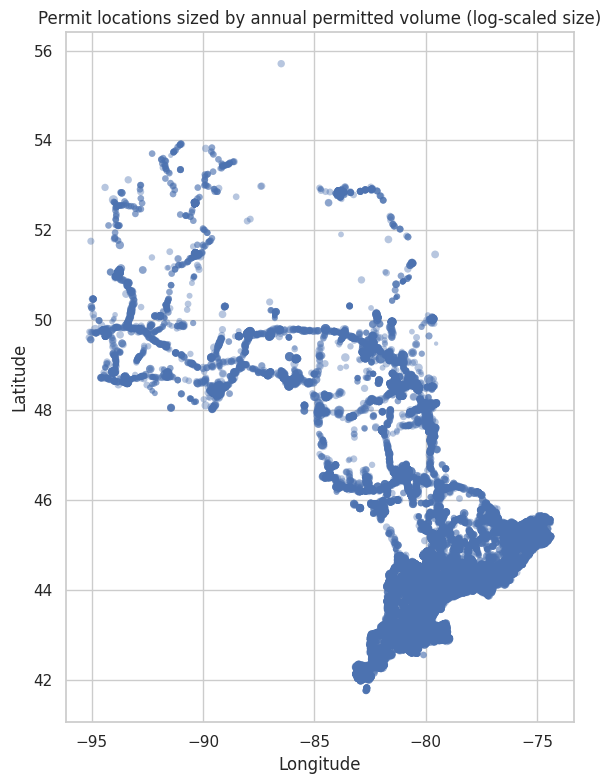

In [12]:
plt.figure(figsize=(6, 8))

mask = geo[geo["max_m3_per_year"] > 0].copy()
sizes = np.log10(mask["max_m3_per_year"] + 1) * 5  # scale factor

plt.scatter(
    mask["longitude"],
    mask["latitude"],
    s=sizes,
    alpha=0.4,
    edgecolor="none"
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Permit locations sized by annual permitted volume (log-scaled size)")
plt.tight_layout()
plt.show()


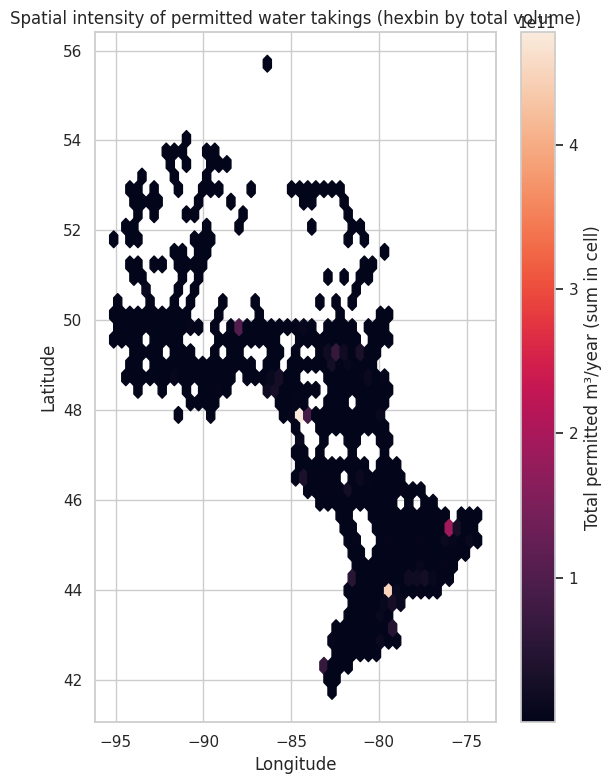

In [13]:
plt.figure(figsize=(6, 8))

mask = geo[["longitude", "latitude", "max_m3_per_year"]].dropna()

hb = plt.hexbin(
    mask["longitude"],
    mask["latitude"],
    C=mask["max_m3_per_year"],
    reduce_C_function=np.sum,
    gridsize=45
)

plt.colorbar(hb, label="Total permitted m³/year (sum in cell)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial intensity of permitted water takings (hexbin by total volume)")
plt.tight_layout()
plt.show()


/tmp/ipython-input-4246380140.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


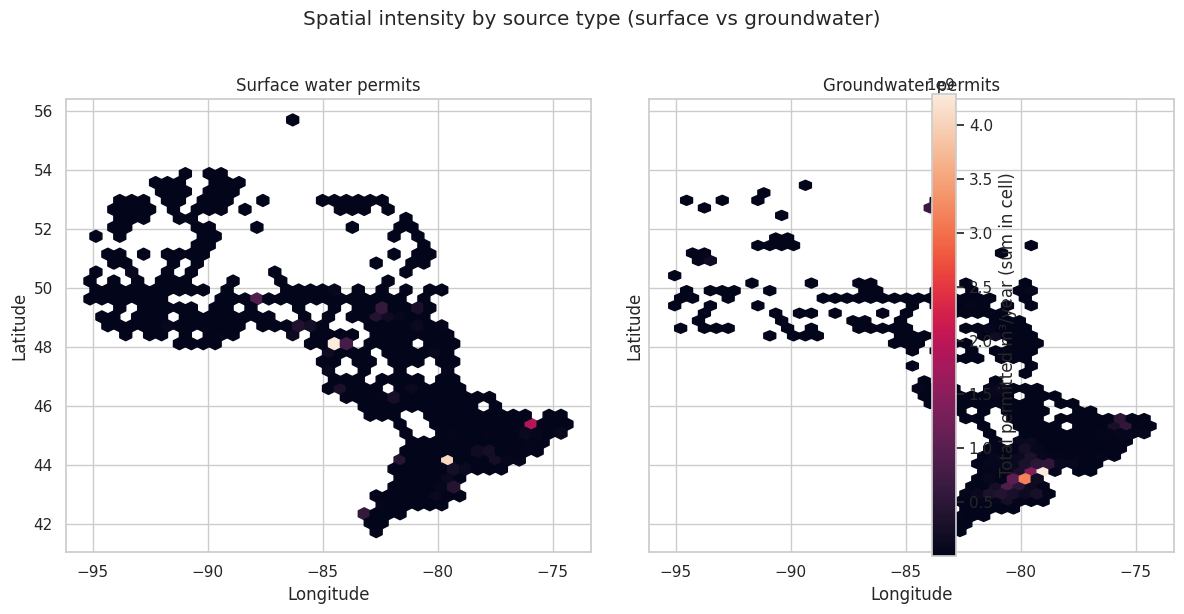

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

for ax, label in zip(axes, ["Surface", "Ground"]):
    if label == "Surface":
        sub = geo[geo["is_surface_water"] == 1]
        title = "Surface water permits"
    else:
        sub = geo[geo["is_groundwater"] == 1]
        title = "Groundwater permits"

    sub = sub[sub["max_m3_per_year"] > 0]

    hb = ax.hexbin(
        sub["longitude"],
        sub["latitude"],
        C=sub["max_m3_per_year"],
        reduce_C_function=np.sum,
        gridsize=40
    )
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

fig.colorbar(hb, ax=axes.ravel().tolist(), label="Total permitted m³/year (sum in cell)")
plt.suptitle("Spatial intensity by source type (surface vs groundwater)", y=1.02)
plt.tight_layout()
plt.show()


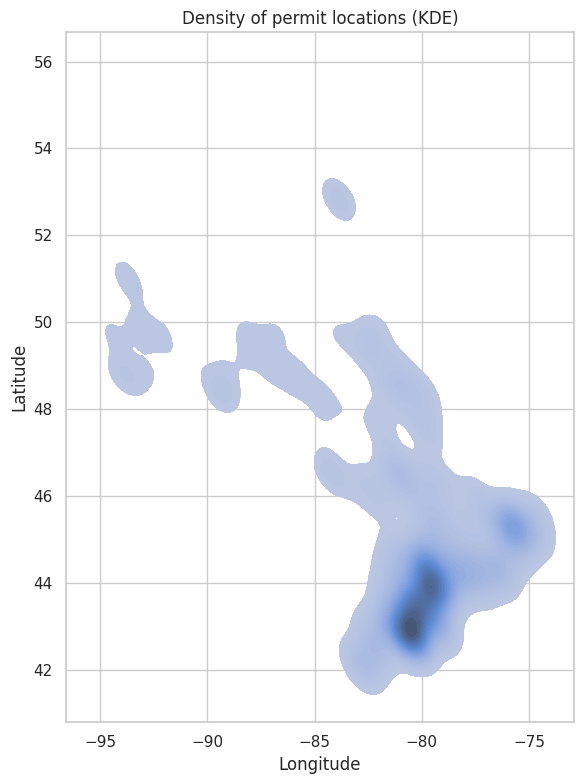

In [15]:
plt.figure(figsize=(6, 8))

sns.kdeplot(
    data=geo,
    x="longitude",
    y="latitude",
    fill=True,
    thresh=0.05,
    levels=30
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Density of permit locations (KDE)")
plt.tight_layout()
plt.show()


In [16]:
# Define grid resolution (degrees)
lat_bins = np.linspace(geo["latitude"].min(), geo["latitude"].max(), 35)
lon_bins = np.linspace(geo["longitude"].min(), geo["longitude"].max(), 35)

geo["lat_bin"] = pd.cut(geo["latitude"], bins=lat_bins, include_lowest=True)
geo["lon_bin"] = pd.cut(geo["longitude"], bins=lon_bins, include_lowest=True)

grid_summary = (
    geo
    .groupby(["lat_bin", "lon_bin"])
    .agg(
        total_m3_per_year=("max_m3_per_year", "sum"),
        permit_count=("permitno", "nunique")
    )
    .reset_index()
)

grid_summary.head()


/tmp/ipython-input-1885240235.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["lat_bin", "lon_bin"])


,lat_bin,lon_bin,total_m3_per_year,permit_count
0,"(41.748000000000005, 42.16]","(-95.11200000000001, -94.502]",0.0,0
1,"(41.748000000000005, 42.16]","(-94.502, -93.892]",0.0,0
2,"(41.748000000000005, 42.16]","(-93.892, -93.282]",0.0,0
3,"(41.748000000000005, 42.16]","(-93.282, -92.672]",0.0,0
4,"(41.748000000000005, 42.16]","(-92.672, -92.062]",0.0,0


/tmp/ipython-input-4243835786.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["lat_mid", "lon_mid"])


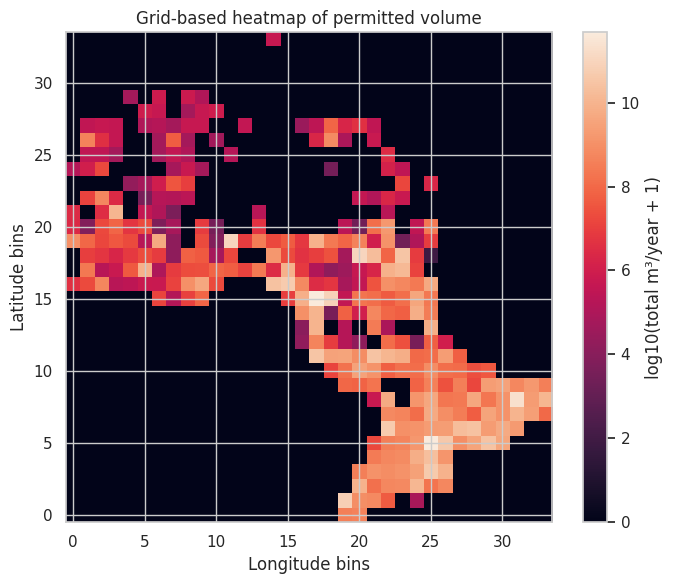

In [17]:
# Use midpoints for plotting
geo["lat_mid"] = geo["lat_bin"].apply(lambda x: x.mid if not pd.isna(x) else np.nan)
geo["lon_mid"] = geo["lon_bin"].apply(lambda x: x.mid if not pd.isna(x) else np.nan)

cell_summary = (
    geo
    .groupby(["lat_mid", "lon_mid"])
    .agg(total_m3_per_year=("max_m3_per_year", "sum"))
    .reset_index()
)

pivot = cell_summary.pivot(index="lat_mid", columns="lon_mid", values="total_m3_per_year")

plt.figure(figsize=(7, 6))
plt.imshow(
    np.log10(pivot + 1),
    origin="lower",
    aspect="auto",
)
plt.colorbar(label="log10(total m³/year + 1)")
plt.title("Grid-based heatmap of permitted volume")
plt.xlabel("Longitude bins")
plt.ylabel("Latitude bins")
plt.tight_layout()
plt.show()


In [18]:
from sklearn.cluster import KMeans

high = geo[geo["max_m3_per_year"] > geo["max_m3_per_year"].quantile(0.9)].copy()

coords = high[["longitude", "latitude"]].dropna()

k = 6  # number of clusters; tweak if needed
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels = kmeans.fit_predict(coords)

high = high.loc[coords.index].copy()
high["cluster"] = labels

centers = pd.DataFrame(kmeans.cluster_centers_, columns=["longitude", "latitude"])
centers["cluster"] = range(k)

high[["longitude", "latitude", "max_m3_per_year", "cluster"]].head()


,longitude,latitude,max_m3_per_year,cluster
4,-79.866693,43.108267,5150880.0,5
35,-80.015770,43.651045,2388852.0,5
38,-79.505357,43.579232,343100000.0,5
41,-80.120968,46.379083,39100000.0,2
47,-79.249951,42.888459,16592900.0,5


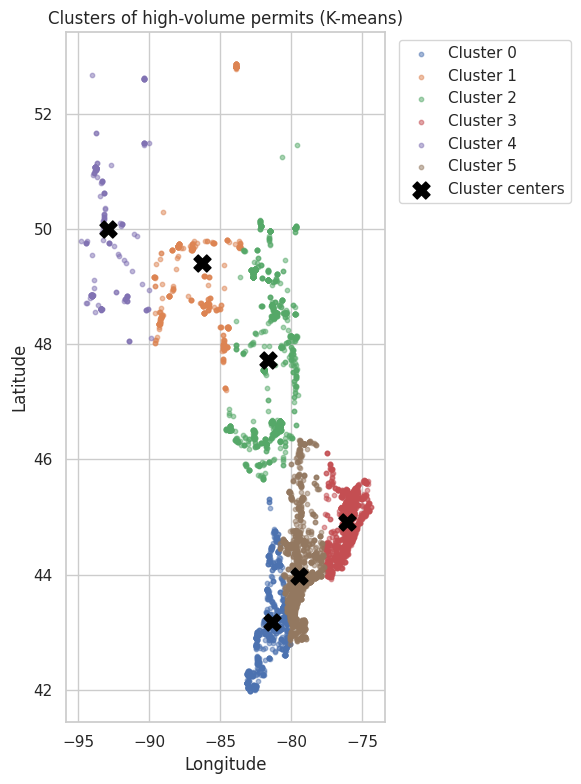

In [19]:
plt.figure(figsize=(6, 8))

for c in range(k):
    sub = high[high["cluster"] == c]
    plt.scatter(
        sub["longitude"],
        sub["latitude"],
        s=10,
        alpha=0.5,
        label=f"Cluster {c}"
    )

plt.scatter(
    centers["longitude"],
    centers["latitude"],
    s=150,
    marker="X",
    color="black",
    label="Cluster centers"
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Clusters of high-volume permits (K-means)")
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0))
plt.tight_layout()
plt.show()


In [20]:
[col for col in geo.columns if "municip" in col.lower()]


['p_municip']

In [22]:
if "p_municip" in geo.columns:
    municip_summary = (
        geo
        .groupby("p_municip")
        .agg(
            permit_count=("permitno", "nunique"),
            total_m3_per_year=("max_m3_per_year", "sum")
        )
        .sort_values("total_m3_per_year", ascending=False)
    )

    municip_summary.head(15)


In [23]:
summaries_dir = "data/processed/spatial_summaries"
os.makedirs(summaries_dir, exist_ok=True)

# grid-based summary
cell_summary.to_csv(os.path.join(summaries_dir, "grid_volume_summary.csv"), index=False)

# high-volume clusters
high[["permitno", "latitude", "longitude", "max_m3_per_year", "cluster"]].to_csv(
    os.path.join(summaries_dir, "high_volume_clusters.csv"),
    index=False
)

# municipality summary if available
if "p_municip" in geo.columns:
    municip_summary.to_csv(
        os.path.join(summaries_dir, "municipality_summary.csv")
    )

os.listdir(summaries_dir)


['grid_volume_summary.csv',
 'municipality_summary.csv',
 'high_volume_clusters.csv']